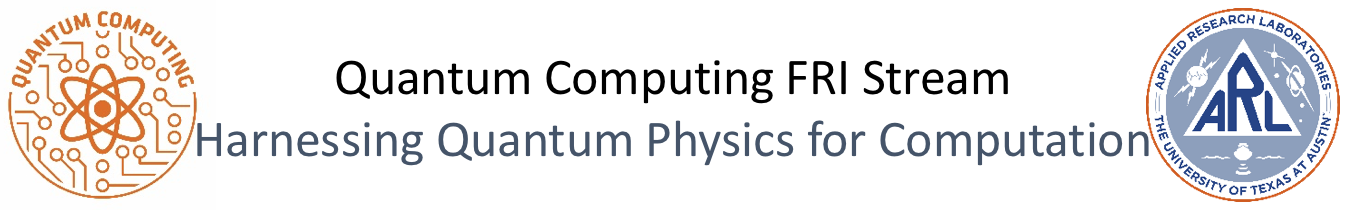

#### Most Recent Lesson: Lesson17 - Perfect Quantum Error Correction

### Installations and Imports

In [1]:
#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister


import numpy as np

In [2]:
def rand(a=0, b=1):
    return a + (b-a)*np.random.random()

## Helper Functions
**You may use these if you do not wish to use mcx and mcp or the qiskit functions to add controls to gates. You do not need to edit these**

The following functions implement special controlled $X, Y, Z$ gates, called multiCX, multiCY, multiCZ, respectively.  Each function takes as its input a quantum register "q_controls" with n control qubits and a quantum register "q_target" with 1 target qubit.  It also has, as an optional argument, a "signature" sig, which is an array with $n$ binary elements.  The controlled gate is applied to q_target only if q_controls[i] = sig[i] for all $i = 0, ..., n-1$.  By default, sig is an array of all ones.

In [3]:
def multiPhase(qc, q, theta):
    # Recursive implementation
    # multi-qubit controlled phase rotation
    # applies a phase factor exp(i*theta) if all the qubits are 1.
    # Note that it doesn't matter which qubits are the controls and which is the target.
    # qc is a quantum circuit
    # q is a quantum register in qc
    # theta is a float
    n = len(q)
    q = [q[i] for i in range(n)]
    if n == 1:
        qc.p(theta, q[0])
    elif n == 2:
        qc.cp(theta, q[0], q[1])
    else:
        qc.cp(theta/2, q[1], q[0])
        multiCX(qc, q[2:], q[1])
        qc.cp(-theta/2, q[1], q[0])
        multiCX(qc, q[2:], q[1])
        multiPhase(qc, [q[0]]+q[2:], theta/2)

    return

def multiCZ(qc, q_controls, q_target, sig=None):
    # multi-qubit controlled Z gate
    # applies a Z gate to q_target if q_controls[i]==sig[i] for all i
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    # sig is the signature of the control (defaults to sig=[1,1,...,1])

    # default signature is an array of n 1s
    n = len(q_controls)
    if sig is None:
        sig = [1] * n

    # apply signature
    for i in range(n):
        if sig[i] == 0:
            qc.x(q_controls[i])

    q = [q_controls[i] for i in range(len(q_controls))] + [q_target]
    multiPhase(qc, q, np.pi)

    # undo signature gates
    for i in range(n):
        if sig[i] == 0:
            qc.x(q_controls[i])

    return

def multiCX(qc, q_controls, q_target, sig=None):
    # multi-qubit controlled X gate
    # applies an X gate to q_target if q_controls[i]==sig[i] for all i
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    # sig is the signature of the control (defaults to sig=[1,1,...,1])

    # default signature is an array of n 1s
    n = len(q_controls)
    if sig is None:
        sig = [1] * n

    # use the fact that H Z H = X to realize a controlled X gate
    qc.h(q_target)
    multiCZ(qc, q_controls, q_target, sig)
    qc.h(q_target)

    return

def multiCY(qc, q_controls, q_target, sig=None):
    # multi-qubit controlled Y gate
    # applies a Y gate to q_target if q_controls[i]==sig[i] for all i
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    # sig is the signature of the control (defaults to sig=[1,1,...,1])

    # default signature is an array of n 1s
    n = len(q_controls)
    if sig is None:
        sig = [1] * n

    # use the fact that X Z = -i Y to realize a controlled Y gate
    multiCX(qc, q_controls, q_target, sig)
    multiCZ(qc, q_controls, q_target, sig)

    return

# Perfect Quantum Error Correction


Use this notebook to implement a QEC protocol that will do the following:
- Prepare a random single-qubit state.
- Encode the qubit using the 5-qubit perfect code.
- Add a syndrome register (auxiliary qubits) and apply gates to diagnose a syndrome.
- Measure the syndrome and use conditional gates to correct the error.
- Then do it without measuring by using controlled gates (self-correcting code).
- Recall that $\texttt{qc.x(q[0]).c\_if(c,2)}$ applies a NOT gate to qubit 0 of the quantum register q if the classical register c is such that $\texttt{c[1] = 1}$ and $\texttt{c[0]= 0}$ (i.e., c = 2 in decimal form, c = 10 in binary).

## Encoding and Decoding

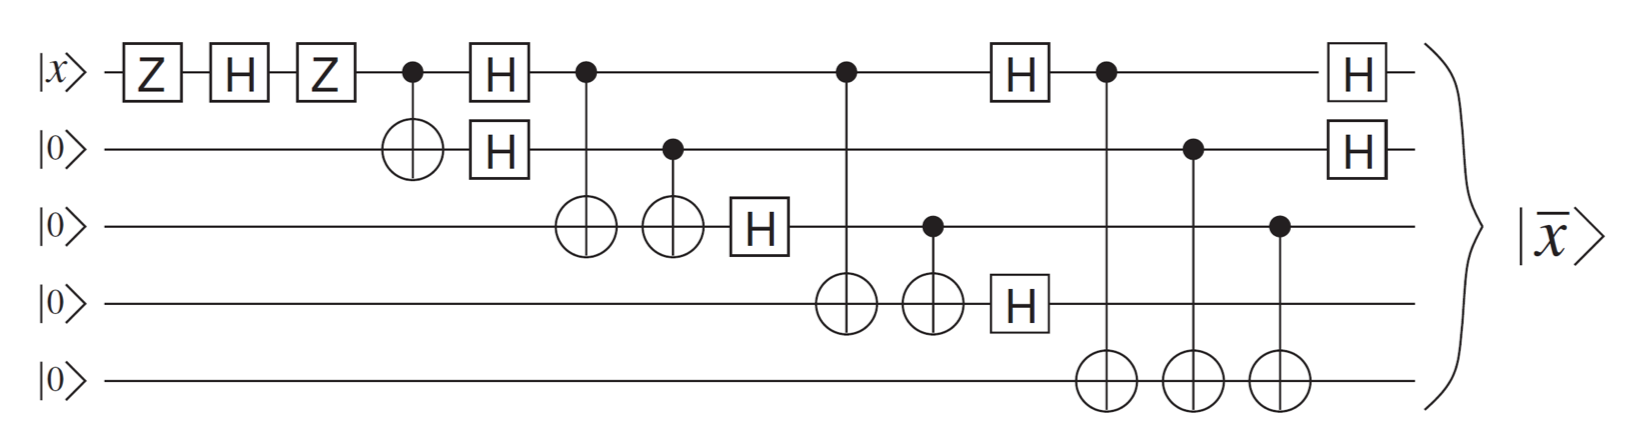

In [4]:
def perfect_encoding(qc, qx):
    # Encode qubit qx[0] using the five-qubit "perfect" code.
    # Put your code here.
    
    qc.z(qx[0])
    qc.h(qx[0])
    qc.z(qx[0])
    qc.barrier()

    qc.cx(qx[0], qx[1])
    qc.h(qx[:2])
    qc.barrier()
    qc.cx(qx[0], qx[2])
    qc.cx(qx[1], qx[2])
    qc.h(qx[2])
    qc.barrier()
    qc.cx(qx[0], qx[3])
    qc.cx(qx[2], qx[3])
    qc.h([qx[0],qx[3]])
    qc.barrier()
    qc.cx(qx[0], qx[4])
    qc.cx(qx[1], qx[4])
    qc.cx(qx[2], qx[4])
    qc.h([qx[0],qx[1]])


    return

In [5]:
def perfect_decoding(qc, qx):
    # Decode qubit qx[0] using the five-qubit "perfect" code.
    # Put your code here.
    # Last layer 
    qc.h([qx[0],qx[1]])
    qc.cx(qx[2], qx[4])
    qc.cx(qx[1], qx[4])
    qc.cx(qx[0], qx[4])
    qc.barrier()
    
    # Second to last layer 
    qc.h([qx[0],qx[3]])
    qc.cx(qx[2], qx[3])
    qc.cx(qx[0], qx[3])
    qc.barrier()
    
    # Middle layer 
    qc.h(qx[2])
    qc.cx(qx[1], qx[2])
    qc.cx(qx[0], qx[2])
    qc.barrier()
    
    # Second layer 
    qc.h(qx[:2])
    qc.cx(qx[0], qx[1])
    qc.barrier()
    
    # First layer 
    qc.z(qx[0])
    qc.h(qx[0])
    qc.z(qx[0])
    return



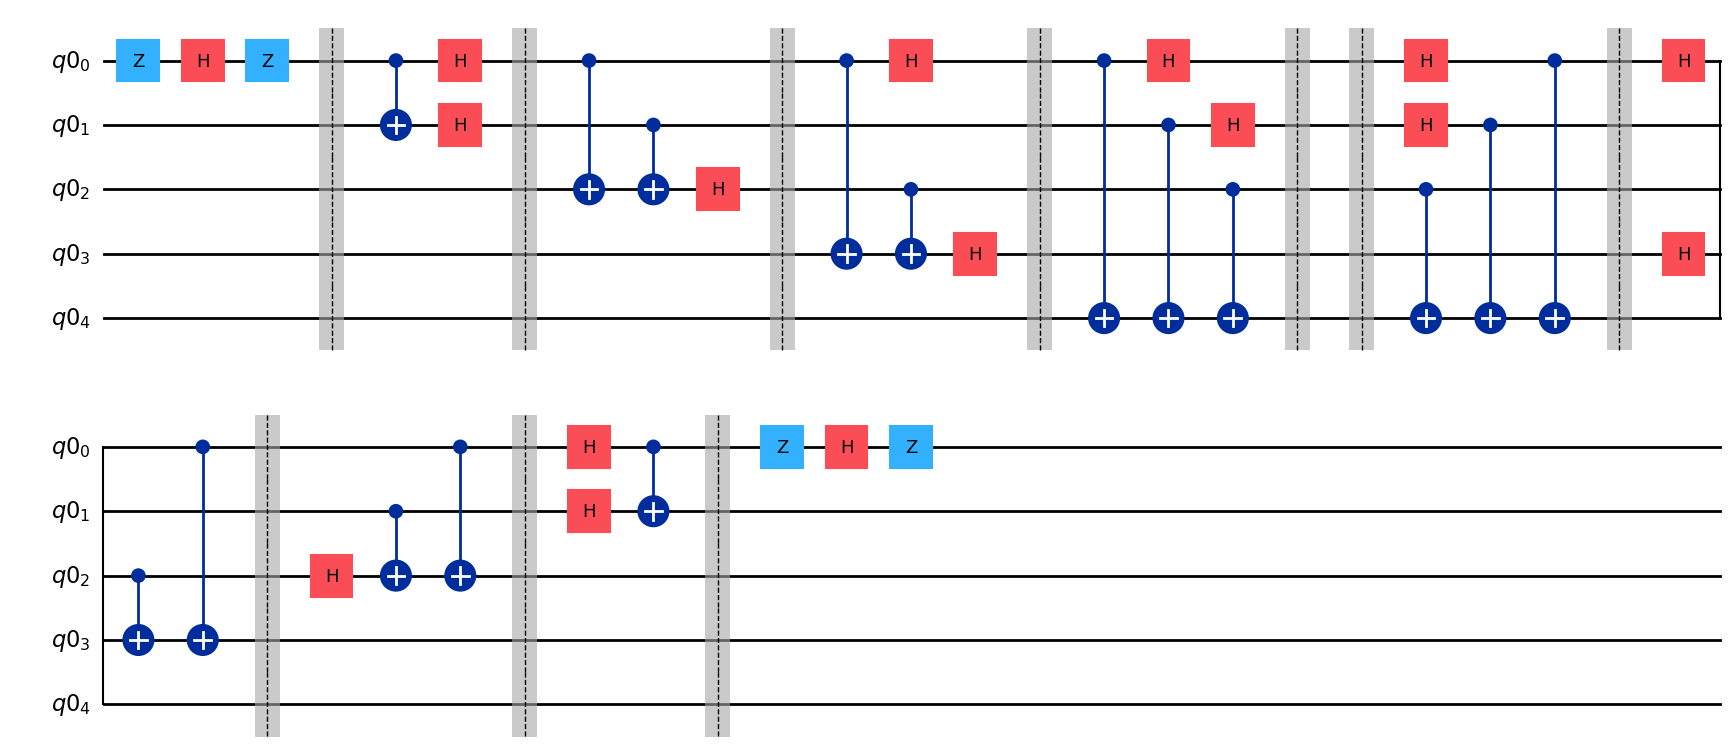

In [6]:
qx=QuantumRegister(5)
qc=QuantumCircuit(qx)

perfect_encoding(qc,qx)
qc.barrier()
qc.barrier()
perfect_decoding(qc,qx)
qc.draw('mpl')

## Error Model
**Do not modify**

In [7]:
def error_model(qc, qx, e=None, k=None):
    # Apply a random single-qubit error to one of the encoding qubits
    # DO NOT MODIFY!

    if (e is None):
        e = np.random.randint(0,5) # 0 = no error, 1 = X error, 2 = Y error, 3 = Z error, 4 = random unitary
    if (k is None):
        k = np.random.randint(0,5) # index of qubit on which error occurs
    print(e)
    if e == 0:
        print("no error")
        pass # no error - do nothing
    elif e == 1:
        print("X error on qubit " + str(k))
        qc.x(qx[k]) # bit-flip error on qubit k
    elif e == 2:
        print("Y error on qubit " + str(k))
        qc.y(qx[k]) # bit-flip & phase error on qubit k
    elif e == 3:
        print("Z error on qubit " + str(k))
        qc.z(qx[k]) # phase error on qubit k
    else:
        print("Random unitary on qubit " + str(k))
        theta = np.arccos(2*rand()-1)
        phi = 2*np.pi*rand()
        lamb = 2*np.pi*rand()
        qc.u(theta, phi, lamb, qx[k])

## Syndrome Measurement

$$\textbf{Stabilizers}$$

$$\begin{align}
\mathbf{M}_{0}=&\mathbf{Z}_{1}\mathbf{X}_{2}\mathbf{X}_{3}\mathbf{Z}_{4} \\
\mathbf{M}_{1}=&\mathbf{Z}_{2}\mathbf{X}_{3}\mathbf{X}_{4}\mathbf{Z}_{0} \\
\mathbf{M}_{2}=&\mathbf{Z}_{3}\mathbf{X}_{4}\mathbf{X}_{0}\mathbf{Z}_{1} \\
\mathbf{M}_{3}=&\mathbf{Z}_{4}\mathbf{X}_{0}\mathbf{X}_{1}\mathbf{Z}_{2} \\
\end{align}$$

In [8]:
def perfect_syndrome(qc, qx, qs):
    # Apply gates to measure the stabilizers
    # Each syndrome qubit measures one stabilizer
    qc.h(qs[0])
    qc.h(qs[1])
    qc.h(qs[2])
    qc.h(qs[3])
    qc.barrier()
    qc.cz(qs[0], qx[1])
    qc.cx(qs[0], qx[2])
    qc.cx(qs[0], qx[3])
    qc.cz(qs[0], qx[4])
    qc.barrier()
    qc.cz(qs[1], qx[2])
    qc.cx(qs[1], qx[3])
    qc.cx(qs[1], qx[4])
    qc.cz(qs[1], qx[0])
    qc.barrier()
    qc.cz(qs[2], qx[3])
    qc.cx(qs[2], qx[4])
    qc.cx(qs[2], qx[0])
    qc.cz(qs[2], qx[1])
    qc.barrier()
    qc.cz(qs[3], qx[4])
    qc.cx(qs[3], qx[0])
    qc.cx(qs[3], qx[1])
    qc.cz(qs[3], qx[2])
    qc.barrier()
    qc.h(qs[0])
    qc.h(qs[1])
    qc.h(qs[2])
    qc.h(qs[3])

    return

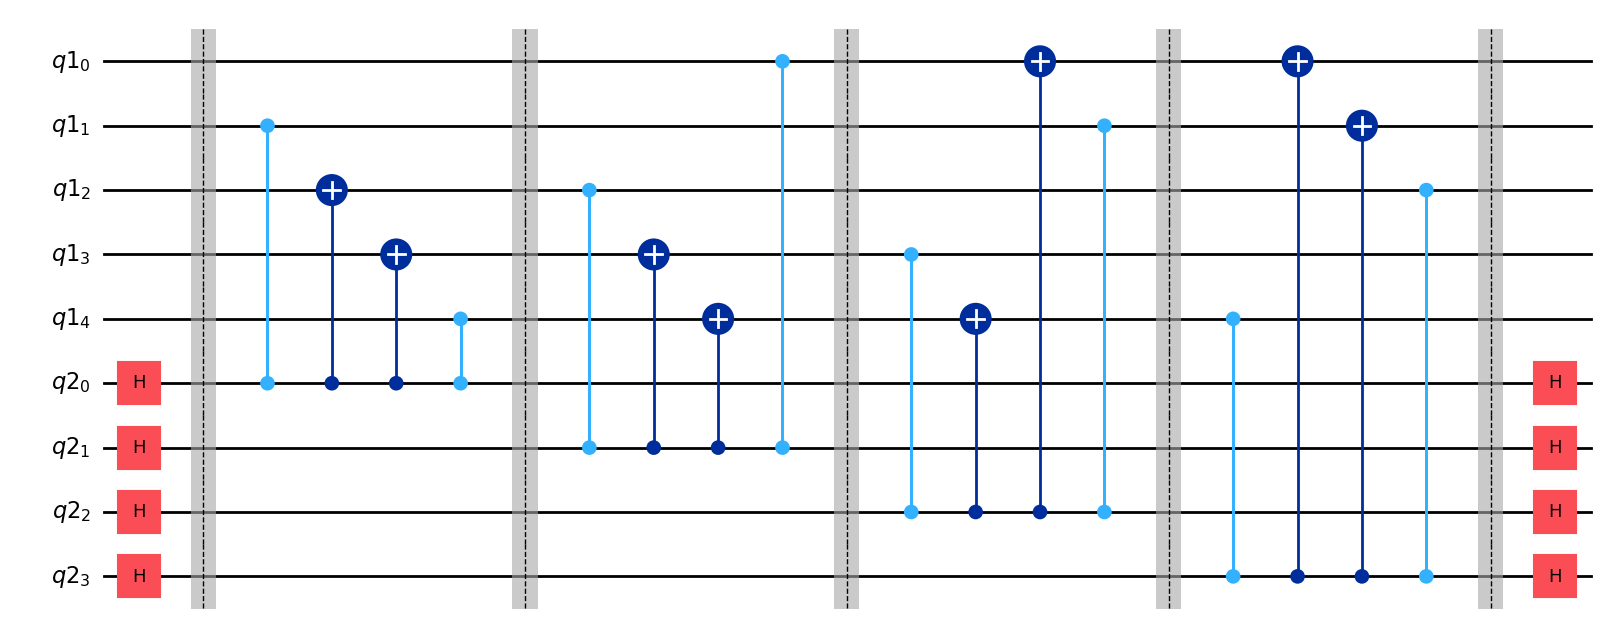

In [9]:
qx = QuantumRegister(5)
qs = QuantumRegister(4)
qc = QuantumCircuit(qx,qs)

perfect_syndrome(qc,qx,qs)

qc.draw('mpl')

## Error Correction

Using this right now as reference
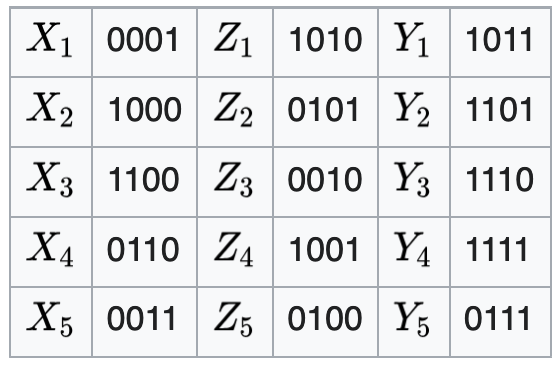

In [10]:
def perfect_qec_conditionals(qc, qx, qs, cs):
    # Correct errors using measured syndromes and conditional gates
    # Put your code here.


    # First qubit corrections
    # X0 (0001)
    qc.x(qx[0]).c_if(cs[3], 1) 

    # Z0 (1010)
    qc.z(qx[0]).c_if(cs[0], 1).c_if(cs[2], 1)  

    # Y0 (1011)
    qc.y(qx[0]).c_if(cs[0], 1).c_if(cs[2], 1).c_if(cs[3],1) 
    
    # Second qubit corrections  
    # X1 (1000)
    qc.x(qx[1]).c_if(cs[0], 1)
    # Z1 (0101)
    qc.z(qx[1]).c_if(cs[1], 1).c_if(cs[3], 1)
    # Y1 (1101)
    qc.y(qx[1]).c_if(cs[0], 1).c_if(cs[1], 1).c_if(cs[3], 1)
    
    # Third qubit corrections
    # X2 (1100)
    qc.x(qx[2]).c_if(cs[0], 1).c_if(cs[1], 1)
    # Z2 (0010)
    qc.z(qx[2]).c_if(cs[2], 1)
    # Y2 (1110)
    qc.y(qx[2]).c_if(cs[0], 1).c_if(cs[1], 1).c_if(cs[2], 1)
    
    # Fourth qubit corrections
    # X3 (0110)
    qc.x(qx[3]).c_if(cs[1], 1).c_if(cs[2], 1)
    # Z3 (1001)
    qc.z(qx[3]).c_if(cs[0], 1).c_if(cs[3], 1)
    # Y3 (1111)
    qc.y(qx[3]).c_if(cs[0], 1).c_if(cs[1], 1).c_if(cs[2], 1).c_if(cs[3], 1)
    
    # Fifth qubit corrections
    # X4 (0011)
    qc.x(qx[4]).c_if(cs[2], 1).c_if(cs[3], 1)
    # Z4 (0100)
    qc.z(qx[4]).c_if(cs[1], 1)
    # Y4 (0111)
    qc.y(qx[4]).c_if(cs[1], 1).c_if(cs[2], 1).c_if(cs[3], 1)
    qc.measure(qs,cs)


In [11]:
# Okay I need to write code which will 
# basically randomly test gates, and loop the whole model
# Until one of the results gives is the pure 0000 register
# a dictionary probably works best here, the key is the
# classical register, the entry is the gate in the first index, 
# and the second index is the target qubit.
gates = {1:['Z',2],2:['X',0],15:['Y',4]}
# the second index has a max valud of 4, and 
# teh first index has posible values of Z,X,Y

# 

In [12]:
import random

def create_error_dict():
    # Fixed positions
    known_gates = {1: ['Z', 2], 2: ['X', 0], 15: ['Y', 4]}
    
    # Create list of all possible combinations
    possible_gates = ['X', 'Y', 'Z']
    possible_qubits = list(range(5))  # 0-4
    
    # Remove combinations that are already used
    used_combinations = []
    for gate_info in known_gates.values():
        used_combinations.append(tuple(gate_info))
    
    # Create all valid remaining combinations
    combinations = []
    for gate in possible_gates:
        for qubit in possible_qubits:
            if tuple([gate, qubit]) not in used_combinations:
                combinations.append([gate, qubit])
    
    # Shuffle remaining combinations
    random.shuffle(combinations)
    
    # Create dictionary starting with known gates
    error_dict = known_gates.copy()
    
    # Fill in remaining positions
    current_combo = 0
    for i in range(1, 16):  # 1 to 15
        if i not in error_dict:
            error_dict[i] = combinations[current_combo]
            current_combo += 1
            
    return error_dict

# Test
gates = create_error_dict()
print(gates)

{1: ['Z', 2], 2: ['X', 0], 15: ['Y', 4], 3: ['Y', 1], 4: ['Z', 1], 5: ['X', 1], 6: ['X', 2], 7: ['Y', 0], 8: ['Z', 0], 9: ['Z', 4], 10: ['Y', 3], 11: ['Y', 2], 12: ['Z', 3], 13: ['X', 4], 14: ['X', 3]}


In [13]:
def guessConditionals(gates,qc, qx, qs, cs):
    for i in range(15):
        if gates[i+1][0] == 'X':
            qc.x(qx[gates[i+1][1]]).c_if(cs, i+1)
        elif gates[i+1][0] == 'Y':
            qc.y(qx[gates[i+1][1]]).c_if(cs, i+1)
        elif gates[i+1][0] == 'Z':
            qc.z(qx[gates[i+1][1]]).c_if(cs, i+1)
    qc.measure(qs,cs)

In [ ]:
def perfect_qec_conditionals(qc, qx, qs, cs):
    # Correct errors using measured syndromes and conditional gates
    qc.measure(qs[0], cs[0])
    qc.measure(qs[1], cs[1])
    qc.measure(qs[2], cs[2])
    qc.measure(qs[3], cs[3])
    
    # X corrections
    with qc.if_test((cs, 2)):
        qc.x(qx[0])
    with qc.if_test((cs, 5)):
        qc.x(qx[1])
    with qc.if_test((cs, 10)):
        qc.x(qx[2])
    with qc.if_test((cs, 4)):
        qc.x(qx[3])
    with qc.if_test((cs, 9)):
        qc.x(qx[4])
    
    # Z corrections
    with qc.if_test((cs, 12)):
        qc.z(qx[0])
    with qc.if_test((cs, 8)):
        qc.z(qx[1])
    with qc.if_test((cs, 1)):
        qc.z(qx[2])
    with qc.if_test((cs, 3)):
        qc.z(qx[3])
    with qc.if_test((cs, 6)):
        qc.z(qx[4])
    
    # Y corrections
    with qc.if_test((cs, 14)):
        qc.y(qx[0])
    with qc.if_test((cs, 13)):
        qc.y(qx[1])
    with qc.if_test((cs, 11)):
        qc.y(qx[2])
    with qc.if_test((cs, 7)):
        qc.y(qx[3])
    with qc.if_test((cs, 15)):
        qc.y(qx[4])
    
    return

## Main Code Block
This executes the entire protocol.

In [15]:
from qiskit_aer import Aer

n = 5 # number of physical qubits
k = 1 # number of logical qubits

# prepare the quantum circuit
qx = QuantumRegister(n)
qs = QuantumRegister(n-k)
cx = ClassicalRegister(n)
cs = ClassicalRegister(n-k)
qc = QuantumCircuit(qx, qs, cx, cs)

# prepare a random single-qubit state in qx[0]
theta = np.arccos(2*rand()-1)
phi = 2*np.pi*rand()
lamb = 0
qc.u(theta, phi, lamb, qx[0])

# encode the qubit using the 5-qubit perfect code
perfect_encoding(qc, qx)

# apply a random error to one of the encoding qubits
error_model(qc, qx, None, 2)

# apply gates to perform a syndrome measurement
perfect_syndrome(qc, qx, qs)

# detect and correct error using the syndromes

perfect_qec_conditionals(qc, qx, qs, cs)
# perfect_qec_controls(qc, qx, qs)

# decode the corrected, encoded qubit
perfect_decoding(qc, qx)

# prepare qubit qx[0] for measurement
qc.u(theta, np.pi-lamb, np.pi-phi, qx[0])

# measure the qx register
for i in range(len(qx)):
    qc.measure(qx[i], cx[i])

# measure the qs register
for j in range(len(qs)):
    qc.measure(qs[j], cs[j])

# execute the quantum circuit
backend =  Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
data = job.result().get_counts(qc)
print(data)

4
Random unitary on qubit 2


AttributeError: 'InstructionSet' object has no attribute 'c_if'

In [ ]:
def mainStuff(guess):
    n = 5 # number of physical qubits
    k = 1 # number of logical qubits

    # prepare the quantum circuit
    qx = QuantumRegister(n)
    qs = QuantumRegister(n-k)
    cx = ClassicalRegister(n)
    cs = ClassicalRegister(n-k)
    qc = QuantumCircuit(qx, qs, cx, cs)

    # prepare a random single-qubit state in qx[0]
    theta = np.arccos(2*rand()-1)
    phi = 2*np.pi*rand()
    lamb = 0
    qc.u(theta, phi, lamb, qx[0])

    # encode the qubit using the 5-qubit perfect code
    perfect_encoding(qc, qx)

    # apply a random error to one of the encoding qubits
    error_model(qc, qx, None, 2)

    # apply gates to perform a syndrome measurement
    perfect_syndrome(qc, qx, qs)

    # detect and correct error using the syndromes
    guessConditionals(guess,qc, qx, qs, cs)

    # perfect_qec_conditionals(qc, qx, qs, cs)
    # perfect_qec_controls(qc, qx, qs)

    # decode the corrected, encoded qubit
    perfect_decoding(qc, qx)

    # prepare qubit qx[0] for measurement
    qc.u(theta, np.pi-lamb, np.pi-phi, qx[0])

    # measure the qx register
    for i in range(len(qx)):
        qc.measure(qx[i], cx[i])

    # measure the qs register
    for j in range(len(qs)):
        qc.measure(qs[j], cs[j])

    # execute the quantum circuit
    backend =  Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=1024)
    data = job.result().get_counts(qc)
    
    return data
